In [1]:
import pandas as pd
import torch

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../Updated_model_nd_dataset/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../Updated_model_nd_dataset/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../Updated_model_nd_dataset/processed_cnv_FXS_OG.csv", index_col=0).T

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")


After transpose - Shapes (samples x features):
gene_df: (205, 60660)
meth_df: (205, 220147)
cnv_df: (205, 56756)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())


NaN counts: 0 0 0


In [4]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)


In [5]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (205, 60660) (205, 220147) (205, 56756)
Shapes: (205, 60660) (205, 220147) (205, 56756)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ Autoencoder with Dropout ------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

# ------------------ Training with validation & early stopping ------------------
def train_autoencoder(model, data, epochs=200, patience=20, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 reg
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        z, recon = model(X_train)
        loss = criterion(recon, X_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recon = model(X_val)
            val_loss = criterion(val_recon, X_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

ae_gene = Autoencoder(gene_dim, latent_dim=64).to(device)
ae_meth = Autoencoder(meth_dim, latent_dim=64).to(device)
ae_cnv  = Autoencoder(cnv_dim,  latent_dim=64).to(device)

ae_gene = train_autoencoder(ae_gene, gene, normalize=True)
ae_meth = train_autoencoder(ae_meth, meth, normalize=True)
ae_cnv  = train_autoencoder(ae_cnv, cnv, normalize=True)

# ------------------ Extract latents & fuse ------------------
ae_gene.eval(); ae_meth.eval(); ae_cnv.eval()
with torch.no_grad():
    z_gene, _ = ae_gene(gene.to(device))
    z_meth, _ = ae_meth(meth.to(device))
    z_cnv,  _ = ae_cnv(cnv.to(device))

z_fused = torch.cat([z_gene, z_meth, z_cnv], dim=1)
print("Fused latent shape:", z_fused.shape)


In [ ]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# ------------------ Diagnostics ------------------
def reconstruction_error_distribution(model, X_train_np, X_val_np, device):
    """Compute and plot per-sample reconstruction errors for train/val."""
    def recon_errors(X_np):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_np, dtype=torch.float32).to(device)
            _, recon = model(X_t)
        errs = ((recon.cpu().numpy() - X_np)**2).mean(axis=1)
        return errs

    errs_train = recon_errors(X_train_np)
    errs_val   = recon_errors(X_val_np)

    # KDE plots
    plt.figure(figsize=(8,5))
    sns.kdeplot(errs_train, label="Train", shade=True)
    sns.kdeplot(errs_val, label="Validation", shade=True)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Train vs Validation Reconstruction Errors")
    plt.legend()
    plt.show()

    print(f"Median Train Err: {np.median(errs_train):.4f} | Median Val Err: {np.median(errs_val):.4f}")

    return errs_train, errs_val

def latent_stability_check(model_class, data, latent_dim, device, n_runs=2):
    """Train AE multiple times and check correlation between latent spaces."""
    latents = []
    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = model_class(data.shape[1], latent_dim=latent_dim).to(device)
        model = train_autoencoder(model, data, normalize=True)
        with torch.no_grad():
            z, _ = model(data.to(device))
        latents.append(z.cpu().numpy())

    # Compare pairwise correlations
    corr = np.corrcoef(latents[0].ravel(), latents[1].ravel())[0,1]
    print(f"Latent stability (corr between runs): {corr:.3f}")

    return corr

# ------------------ Example usage ------------------
# After training each AE, run diagnostics:
# (inside train_autoencoder, you already split train/val)

# 1. Check per-sample reconstruction errors
X_train_np, X_val_np = train_test_split(gene.cpu().numpy(), test_size=0.2, random_state=42)
errs_train, errs_val = reconstruction_error_distribution(ae_gene, X_train_np, X_val_np, device)

# 2. Latent stability
latent_stability_check(Autoencoder, gene, latent_dim=64, device=device)

# 3. (Optional) Quick clustering sanity check on fused latents
from sklearn.cluster import KMeans
z_np = z_fused.cpu().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(z_np)
score = silhouette_score(z_np, kmeans.labels_)
print("Silhouette on fused latents:", score)


In [8]:
from sklearn.cluster import KMeans

# number of clusters: if unknown, try different values & compare
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused.cpu().numpy())


In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X = z_fused.cpu().numpy()

sil_score = silhouette_score(X, cluster_labels)
ch_score  = calinski_harabasz_score(X, cluster_labels)
db_score  = davies_bouldin_score(X, cluster_labels)

print("Silhouette Score:", sil_score)              # higher is better ([-1, 1])
print("Calinski-Harabasz Score:", ch_score)        # higher is better
print("Davies-Bouldin Score:", db_score)           # lower is better



Silhouette Score: 0.3683267831802368
Calinski-Harabasz Score: 88.0234375
Davies-Bouldin Score: 0.9673830862667222


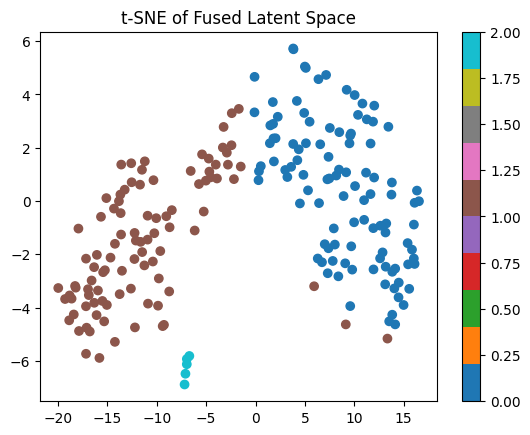

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused.cpu().numpy())

plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE of Fused Latent Space")
plt.show()


# Supervised Machine Learning Evaluation

Now let's train multiple classifiers on the fused features and evaluate with detailed metrics.

In [11]:
# Load subtype labels
labels_df = pd.read_csv("../Updated_model_nd_dataset/subtype_encoded_FXS_MOFA_3Omics.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Filter data and labels to common samples
labels = labels_df.loc[common_samples].values.ravel()
z_fused_labeled = z_fused.cpu().numpy()

# If data was already aligned, we might need to reindex
if len(common_samples) < len(gene_df):
    # Refilter if needed
    gene_idx = gene_df.index.get_indexer(common_samples)
    z_fused_labeled = z_fused.cpu().numpy()[gene_idx]

print(f"Final data shape: {z_fused_labeled.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

Samples with labels: 198
Final data shape: (198, 192)
Labels shape: (198,)
Unique classes: [0 1 2 3]
Class distribution: [51 22 93 32]


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import seaborn as sns

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    z_fused_labeled, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
print(f"Test class distribution: {np.bincount(y_test.astype(int))}")

Training set size: 158
Test set size: 40
Training class distribution: [41 18 74 25]
Test class distribution: [10  4 19  7]


In [17]:
# Define multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Store results
results = []

print("Training and evaluating classifiers...\n")
print("="*80)

for name, clf in classifiers.items():
    print(f"\n{name}:")
    print("-"*80)
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro
    })
    
    # Print metrics
    # print(f"Accuracy:           {accuracy:.4f}")
    # print(f"Precision (Macro):  {precision_macro:.4f}")
    # print(f"Precision (Micro):  {precision_micro:.4f}")
    # print(f"Recall (Macro):     {recall_macro:.4f}")
    # print(f"Recall (Micro):     {recall_micro:.4f}")
    # print(f"F1-Score (Macro):   {f1_macro:.4f}")
    # print(f"F1-Score (Micro):   {f1_micro:.4f}")

print("\n" + "="*80)

Training and evaluating classifiers...


Random Forest:
--------------------------------------------------------------------------------

Gradient Boosting:
--------------------------------------------------------------------------------

Gradient Boosting:
--------------------------------------------------------------------------------

SVM (RBF):
--------------------------------------------------------------------------------

SVM (Linear):
--------------------------------------------------------------------------------

Logistic Regression:
--------------------------------------------------------------------------------

SVM (RBF):
--------------------------------------------------------------------------------

SVM (Linear):
--------------------------------------------------------------------------------

Logistic Regression:
--------------------------------------------------------------------------------


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



K-Nearest Neighbors:
--------------------------------------------------------------------------------

Naive Bayes:
--------------------------------------------------------------------------------

Decision Tree:
--------------------------------------------------------------------------------




SUMMARY OF ALL MODELS
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
Logistic Regression     0.775           0.748377              0.775        0.679699           0.775    0.698485       0.775
       SVM (Linear)     0.700           0.611472              0.700        0.595113           0.700    0.595076       0.700
K-Nearest Neighbors     0.700           0.688949              0.700        0.605827           0.700    0.631602       0.700
      Random Forest     0.675           0.729167              0.675        0.547556           0.675    0.549819       0.675
        Naive Bayes     0.675           0.738636              0.675        0.588440           0.675    0.597863       0.675
      Decision Tree     0.675           0.585833              0.675        0.535714           0.675    0.528030       0.675
  Gradient Boosting     0.625           0.457500              0.625        0.445113           0.625    0.4431

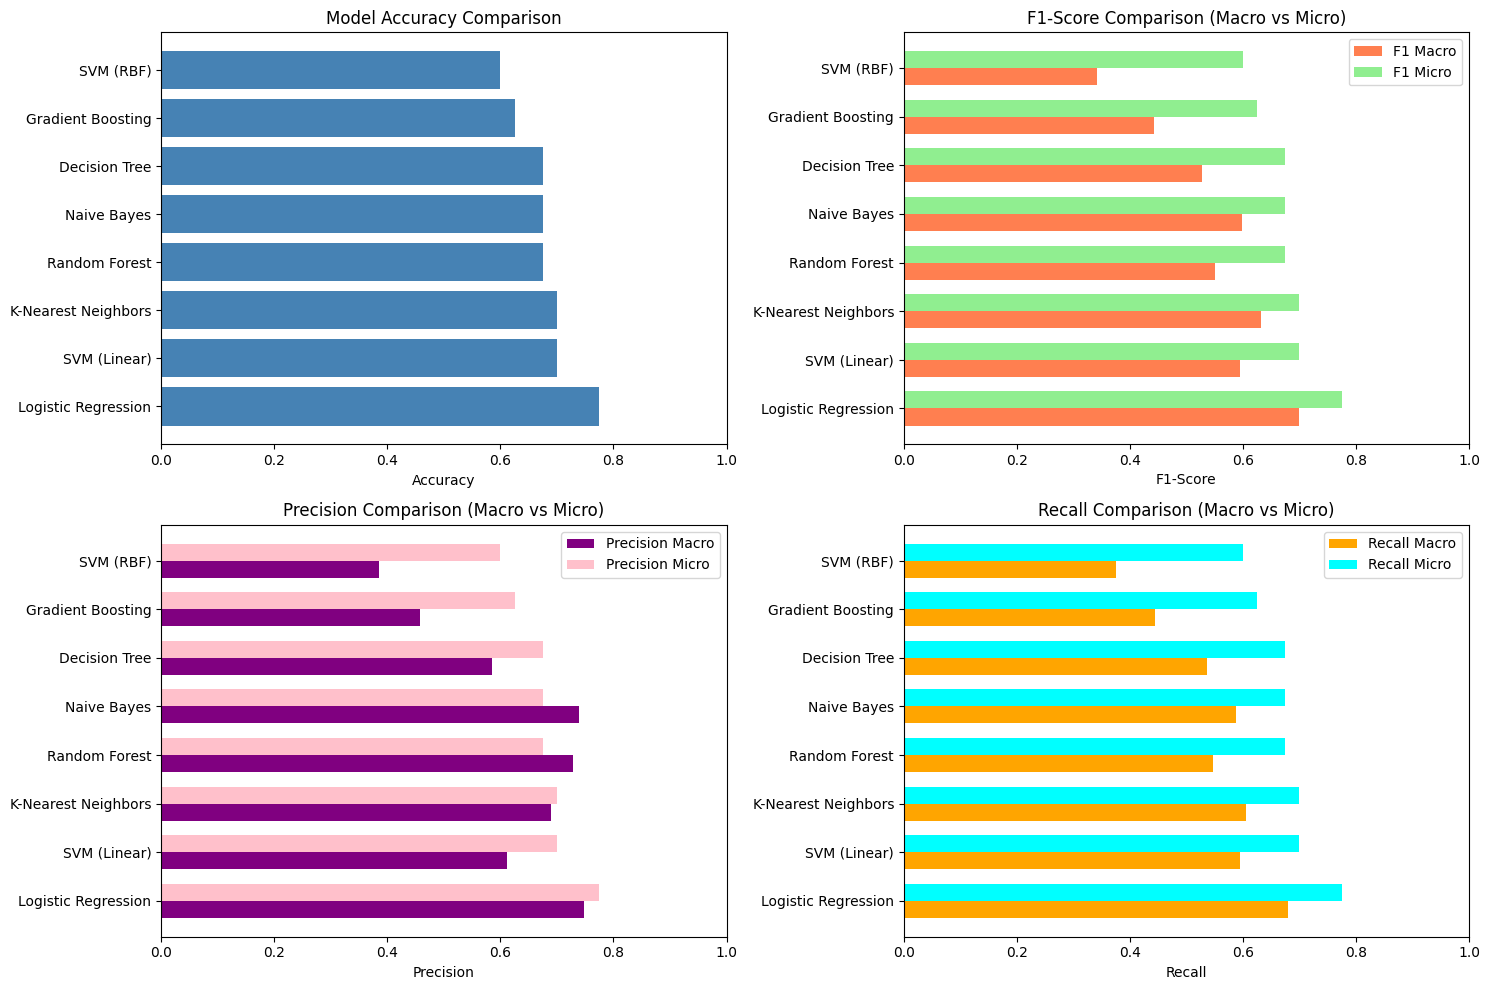

In [18]:
# Create a summary dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])

# Plot 2: F1-Score comparison (Macro and Micro)
x = np.arange(len(results_df))
width = 0.35
axes[0, 1].barh(x - width/2, results_df['F1 (Macro)'], width, label='F1 Macro', color='coral')
axes[0, 1].barh(x + width/2, results_df['F1 (Micro)'], width, label='F1 Micro', color='lightgreen')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(results_df['Model'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison (Macro vs Micro)')
axes[0, 1].legend()
axes[0, 1].set_xlim([0, 1])

# Plot 3: Precision comparison
axes[1, 0].barh(x - width/2, results_df['Precision (Macro)'], width, label='Precision Macro', color='purple')
axes[1, 0].barh(x + width/2, results_df['Precision (Micro)'], width, label='Precision Micro', color='pink')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(results_df['Model'])
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Precision Comparison (Macro vs Micro)')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])

# Plot 4: Recall comparison
axes[1, 1].barh(x - width/2, results_df['Recall (Macro)'], width, label='Recall Macro', color='orange')
axes[1, 1].barh(x + width/2, results_df['Recall (Micro)'], width, label='Recall Micro', color='cyan')
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(results_df['Model'])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Recall Comparison (Macro vs Micro)')
axes[1, 1].legend()
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()


DETAILED REPORT FOR BEST MODEL: Logistic Regression

Classification Report (per-class metrics):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.6364    0.7000    0.6667        10
           1     0.5000    0.5000    0.5000         4
           2     0.8571    0.9474    0.9000        19
           3     1.0000    0.5714    0.7273         7

    accuracy                         0.7750        40
   macro avg     0.7484    0.6797    0.6985        40
weighted avg     0.7912    0.7750    0.7714        40



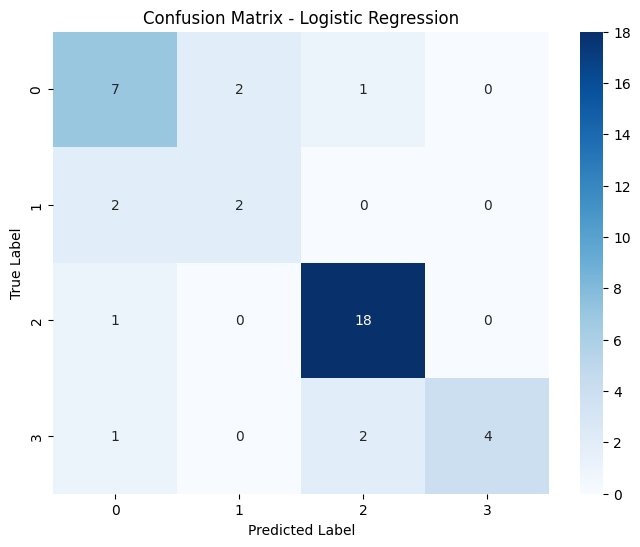


Confusion Matrix:
[[ 7  2  1  0]
 [ 2  2  0  0]
 [ 1  0 18  0]
 [ 1  0  2  4]]


In [19]:
# Detailed classification report for the best model
best_model_name = results_df.iloc[0]['Model']
best_clf = classifiers[best_model_name]

print(f"\n{'='*80}")
print(f"DETAILED REPORT FOR BEST MODEL: {best_model_name}")
print(f"{'='*80}\n")

# Retrain on the data (already trained, but for clarity)
y_pred_best = best_clf.predict(X_test)

# Classification report
print("Classification Report (per-class metrics):")
print("-"*80)
print(classification_report(y_test, y_pred_best, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print(f"\nConfusion Matrix:")
print(cm)

In [16]:
# Cross-validation for the top 3 models
print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print(f"{'='*80}\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (name, clf) in enumerate(list(classifiers.items())[:3]):  # Top 3 models
    scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(clf, z_fused_labeled, labels, cv=cv, scoring='f1_macro')
    
    print(f"{name}:")
    print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    print()


CROSS-VALIDATION RESULTS (5-Fold Stratified)

Random Forest:
  Accuracy: 0.6667 (+/- 0.0659)
  F1-Macro: 0.5615 (+/- 0.0725)

Random Forest:
  Accuracy: 0.6667 (+/- 0.0659)
  F1-Macro: 0.5615 (+/- 0.0725)

Gradient Boosting:
  Accuracy: 0.6314 (+/- 0.0598)
  F1-Macro: 0.5136 (+/- 0.0477)

SVM (RBF):
  Accuracy: 0.6262 (+/- 0.0206)
  F1-Macro: 0.4151 (+/- 0.0507)

Gradient Boosting:
  Accuracy: 0.6314 (+/- 0.0598)
  F1-Macro: 0.5136 (+/- 0.0477)

SVM (RBF):
  Accuracy: 0.6262 (+/- 0.0206)
  F1-Macro: 0.4151 (+/- 0.0507)

